# Method 3 - Rest Ideas After 20

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calculate Intra-Portfolio Cap Weight

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Calculate Intra-Portfolio Cap Weight Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 20].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

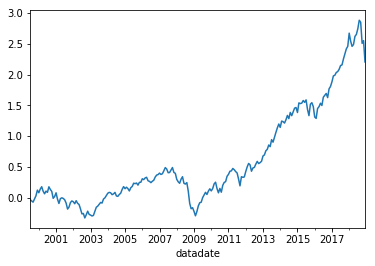

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.122719
2000-12-31   -0.092827
2001-12-31   -0.070326
2002-12-31   -0.229700
2003-12-31    0.419780
2004-12-31    0.139111
2005-12-31    0.060301
2006-12-31    0.099738
2007-12-31    0.014739
2008-12-31   -0.400158
2009-12-31    0.366565
2010-12-31    0.178150
2011-12-31   -0.008214
2012-12-31    0.190543
2013-12-31    0.380307
2014-12-31    0.122112
2015-12-31    0.006678
2016-12-31    0.131430
2017-12-31    0.231986
2018-12-31   -0.073290
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     3614.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.42e-205
Time:                        13:12:01   Log-Likelihood:                 870.45
No. Observations:                 234   AIC:                            -1731.
Df Residuals:                     229   BIC:                            -1714.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      4.249      0.000       0.001       0.003
mktrf          1.0216      0.011     92.394      0.000       1.000       1.043
me             0.1161      0.013      9.030      0.000       0.091       0.141
ia             0.0019      0.020      0.098      0.922      -0.037       0.040
roe           -0.0406      0.017     -2.427      0.016      -0.074      -0.008
==============================================================================
Omnibus:                        6.014   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.049   Jarque-Bera (JB):                9.134
Skew:                          -0.044   Prob(JB):                       0.0104
Kurtosis:                       3.964   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     1615.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.78e-166
Time:                        13:12:01   Log-Likelihood:                 870.45
No. Observations:                 234   AIC:                            -1731.
Df Residuals:                     229   BIC:                            -1714.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      3.627      0.000       0.001       0.003
mktrf          1.0216      0.013     76.858      0.000       0.996       1.048
me             0.1161      0.017      6.933      0.000       0.083       0.149
ia             0.0019      0.032      0.059      0.953      -0.062       0.065
roe           -0.0406      0.025     -1.656      0.098      -0.089       0.007
==============================================================================
Omnibus:                        6.014   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.049   Jarque-Bera (JB):                9.134
Skew:                          -0.044   Prob(JB):                       0.0104
Kurtosis:                       3.964   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     1466.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.55e-162
Time:                        13:12:01   Log-Likelihood:                 870.45
No. Observations:                 234   AIC:                            -1731.
Df Residuals:                     229   BIC:                            -1714.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      3.542      0.000       0.001       0.003
mktrf          1.0216      0.014     73.737      0.000       0.994       1.049
me             0.1161      0.016      7.484      0.000       0.086       0.147
ia             0.0019      0.034      0.057      0.955      -0.064       0.068
roe           -0.0406      0.029     -1.423      0.155      -0.097       0.015
==============================================================================
Omnibus:                        6.014   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.049   Jarque-Bera (JB):                9.134
Skew:                          -0.044   Prob(JB):                       0.0104
Kurtosis:                       3.964   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     3145.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.42e-208
Time:                        13:12:01   Log-Likelihood:                 880.65
No. Observations:                 234   AIC:                            -1749.
Df Residuals:                     228   BIC:                            -1729.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.000      4.097      0.000       0.001       0.002
mktrf          1.0272      0.011     96.634      0.000       1.006       1.048
smb            0.1239      0.014      8.831      0.000       0.096       0.151
hml            0.0179      0.017      1.083      0.280      -0.015       0.050
rmw           -0.0524      0.019     -2.801      0.006      -0.089      -0.016
cma           -0.0050      0.024     -0.211      0.833      -0.052       0.042
==============================================================================
Omnibus:                       10.675   Durbin-Watson:                   1.790
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               22.809
Skew:                           0.063   Prob(JB):                     1.11e-05
Kurtosis:                       4.524   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     2973.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.45e-205
Time:                        13:12:01   Log-Likelihood:                 880.65
No. Observations:                 234   AIC:                            -1749.
Df Residuals:                     228   BIC:                            -1729.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.000      3.795      0.000       0.001       0.002
mktrf          1.0272      0.010    106.916      0.000       1.008       1.046
smb            0.1239      0.019      6.537      0.000       0.087       0.161
hml            0.0179      0.032      0.565      0.572      -0.044       0.080
rmw           -0.0524      0.026     -2.039      0.041      -0.103      -0.002
cma           -0.0050      0.033     -0.152      0.879      -0.069       0.059
==============================================================================
Omnibus:                       10.675   Durbin-Watson:                   1.790
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               22.809
Skew:                           0.063   Prob(JB):                     1.11e-05
Kurtosis:                       4.524   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     3530.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.01e-213
Time:                        13:12:01   Log-Likelihood:                 880.65
No. Observations:                 234   AIC:                            -1749.
Df Residuals:                     228   BIC:                            -1729.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.000      3.606      0.000       0.001       0.002
mktrf          1.0272      0.009    111.199      0.000       1.009       1.045
smb            0.1239      0.016      7.640      0.000       0.092       0.156
hml            0.0179      0.033      0.537      0.591      -0.047       0.083
rmw           -0.0524      0.029     -1.819      0.069      -0.109       0.004
cma           -0.0050      0.033     -0.151      0.880      -0.070       0.060
==============================================================================
Omnibus:                       10.675   Durbin-Watson:                   1.790
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               22.809
Skew:                           0.063   Prob(JB):                     1.11e-05
Kurtosis:                       4.524   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     3783.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          8.24e-208
Time:                        13:12:01   Log-Likelihood:                 875.72
No. Observations:                 234   AIC:                            -1741.
Df Residuals:                     229   BIC:                            -1724.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.000      3.855      0.000       0.001       0.002
mktrf          1.0312      0.010    103.603      0.000       1.012       1.051
smb            0.1390      0.012     11.185      0.000       0.114       0.163
hml            0.0188      0.012      1.522      0.129      -0.006       0.043
umd           -0.0231      0.008     -2.852      0.005      -0.039      -0.007
==============================================================================
Omnibus:                        7.552   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.023   Jarque-Bera (JB):               13.127
Skew:                          -0.027   Prob(JB):                      0.00141
Kurtosis:                       4.159   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     2913.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.90e-195
Time:                        13:12:01   Log-Likelihood:                 875.72
No. Observations:                 234   AIC:                            -1741.
Df Residuals:                     229   BIC:                            -1724.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.000      3.094      0.002       0.001       0.002
mktrf          1.0312      0.012     83.642      0.000       1.007       1.055
smb            0.1390      0.015      9.274      0.000       0.110       0.168
hml            0.0188      0.028      0.660      0.510      -0.037       0.075
umd           -0.0231      0.011     -2.080      0.038      -0.045      -0.001
==============================================================================
Omnibus:                        7.552   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.023   Jarque-Bera (JB):               13.127
Skew:                          -0.027   Prob(JB):                      0.00141
Kurtosis:                       4.159   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     3307.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.09e-201
Time:                        13:12:01   Log-Likelihood:                 875.72
No. Observations:                 234   AIC:                            -1741.
Df Residuals:                     229   BIC:                            -1724.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      2.909      0.004       0.000       0.002
mktrf          1.0312      0.012     85.069      0.000       1.007       1.055
smb            0.1390      0.015      9.112      0.000       0.109       0.169
hml            0.0188      0.032      0.592      0.554      -0.043       0.081
umd           -0.0231      0.011     -2.065      0.039      -0.045      -0.001
==============================================================================
Omnibus:                        7.552   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.023   Jarque-Bera (JB):               13.127
Skew:                          -0.027   Prob(JB):                      0.00141
Kurtosis:                       4.159   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     2084.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.82e-106
Time:                        13:12:01   Log-Likelihood:                 441.97
No. Observations:                 120   AIC:                            -873.9
Df Residuals:                     115   BIC:                            -860.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      3.460      0.001       0.001       0.003
mktrf          1.0108      0.016     63.099      0.000       0.979       1.043
me             0.1047      0.016      6.618      0.000       0.073       0.136
ia             0.0460      0.025      1.856      0.066      -0.003       0.095
roe           -0.0696      0.022     -3.172      0.002      -0.113      -0.026
==============================================================================
Omnibus:                        2.898   Durbin-Watson:                   1.699
Prob(Omnibus):                  0.235   Jarque-Bera (JB):                2.733
Skew:                          -0.128   Prob(JB):                        0.255
Kurtosis:                       3.694   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     1064.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.22e-90
Time:                        13:12:01   Log-Likelihood:                 441.97
No. Observations:                 120   AIC:                            -873.9
Df Residuals:                     115   BIC:                            -860.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      2.791      0.005       0.001       0.003
mktrf          1.0108      0.020     50.043      0.000       0.971       1.050
me             0.1047      0.018      5.705      0.000       0.069       0.141
ia             0.0460      0.037      1.249      0.212      -0.026       0.118
roe           -0.0696      0.028     -2.528      0.011      -0.123      -0.016
==============================================================================
Omnibus:                        2.898   Durbin-Watson:                   1.699
Prob(Omnibus):                  0.235   Jarque-Bera (JB):                2.733
Skew:                          -0.128   Prob(JB):                        0.255
Kurtosis:                       3.694   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     1456.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.81e-97
Time:                        13:12:01   Log-Likelihood:                 441.97
No. Observations:                 120   AIC:                            -873.9
Df Residuals:                     115   BIC:                            -860.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      2.590      0.010       0.000       0.004
mktrf          1.0108      0.019     52.249      0.000       0.973       1.049
me             0.1047      0.019      5.628      0.000       0.068       0.141
ia             0.0460      0.034      1.370      0.171      -0.020       0.112
roe           -0.0696      0.031     -2.220      0.026      -0.131      -0.008
==============================================================================
Omnibus:                        2.898   Durbin-Watson:                   1.699
Prob(Omnibus):                  0.235   Jarque-Bera (JB):                2.733
Skew:                          -0.128   Prob(JB):                        0.255
Kurtosis:                       3.694   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     1532.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.71e-103
Time:                        13:12:01   Log-Likelihood:                 437.49
No. Observations:                 120   AIC:                            -863.0
Df Residuals:                     114   BIC:                            -846.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      3.877      0.000       0.001       0.004
mktrf          1.0490      0.018     59.560      0.000       1.014       1.084
smb            0.1311      0.020      6.574      0.000       0.092       0.171
hml            0.0073      0.024      0.298      0.767      -0.041       0.056
rmw           -0.0373      0.029     -1.293      0.199      -0.094       0.020
cma            0.0484      0.032      1.532      0.128      -0.014       0.111
==============================================================================
Omnibus:                        8.051   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.018   Jarque-Bera (JB):               13.886
Skew:                          -0.207   Prob(JB):                     0.000966
Kurtosis:                       4.614   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     1943.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.56e-108
Time:                        13:12:01   Log-Likelihood:                 437.49
No. Observations:                 120   AIC:                            -863.0
Df Residuals:                     114   BIC:                            -846.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      3.441      0.001       0.001       0.004
mktrf          1.0490      0.017     61.024      0.000       1.015       1.083
smb            0.1311      0.027      4.806      0.000       0.078       0.185
hml            0.0073      0.052      0.141      0.888      -0.094       0.109
rmw           -0.0373      0.039     -0.946      0.344      -0.114       0.040
cma            0.0484      0.037      1.318      0.187      -0.024       0.120
==============================================================================
Omnibus:                        8.051   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.018   Jarque-Bera (JB):               13.886
Skew:                          -0.207   Prob(JB):                     0.000966
Kurtosis:                       4.614   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     3529.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.55e-123
Time:                        13:12:01   Log-Likelihood:                 437.49
No. Observations:                 120   AIC:                            -863.0
Df Residuals:                     114   BIC:                            -846.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      3.222      0.001       0.001       0.004
mktrf          1.0490      0.014     74.295      0.000       1.021       1.077
smb            0.1311      0.024      5.458      0.000       0.084       0.178
hml            0.0073      0.056      0.130      0.896      -0.102       0.117
rmw           -0.0373      0.043     -0.868      0.385      -0.121       0.047
cma            0.0484      0.036      1.347      0.178      -0.022       0.119
==============================================================================
Omnibus:                        8.051   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.018   Jarque-Bera (JB):               13.886
Skew:                          -0.207   Prob(JB):                     0.000966
Kurtosis:                       4.614   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     1836.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.72e-103
Time:                        13:12:01   Log-Likelihood:                 434.48
No. Observations:                 120   AIC:                            -859.0
Df Residuals:                     115   BIC:                            -845.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      4.002      0.000       0.001       0.004
mktrf          1.0382      0.015     69.108      0.000       1.008       1.068
smb            0.1480      0.017      8.654      0.000       0.114       0.182
hml            0.0371      0.017      2.166      0.032       0.003       0.071
umd           -0.0245      0.011     -2.318      0.022      -0.045      -0.004
==============================================================================
Omnibus:                        6.478   Durbin-Watson:                   1.808
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                8.461
Skew:                          -0.263   Prob(JB):                       0.0145
Kurtosis:                       4.189   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     1610.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.29e-100
Time:                        13:12:01   Log-Likelihood:                 434.48
No. Observations:                 120   AIC:                            -859.0
Df Residuals:                     115   BIC:                            -845.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      3.691      0.000       0.001       0.004
mktrf          1.0382      0.018     57.721      0.000       1.003       1.073
smb            0.1480      0.020      7.452      0.000       0.109       0.187
hml            0.0371      0.038      0.976      0.329      -0.037       0.112
umd           -0.0245      0.014     -1.777      0.076      -0.051       0.003
==============================================================================
Omnibus:                        6.478   Durbin-Watson:                   1.808
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                8.461
Skew:                          -0.263   Prob(JB):                       0.0145
Kurtosis:                       4.189   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     2063.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.12e-106
Time:                        13:12:01   Log-Likelihood:                 434.48
No. Observations:                 120   AIC:                            -859.0
Df Residuals:                     115   BIC:                            -845.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      3.593      0.000       0.001       0.004
mktrf          1.0382      0.015     67.267      0.000       1.008       1.068
smb            0.1480      0.022      6.861      0.000       0.106       0.190
hml            0.0371      0.042      0.884      0.377      -0.045       0.119
umd           -0.0245      0.014     -1.714      0.087      -0.052       0.004
==============================================================================
Omnibus:                        6.478   Durbin-Watson:                   1.808
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                8.461
Skew:                          -0.263   Prob(JB):                       0.0145
Kurtosis:                       4.189   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     1612.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.77e-96
Time:                        13:12:01   Log-Likelihood:                 438.71
No. Observations:                 114   AIC:                            -867.4
Df Residuals:                     109   BIC:                            -853.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      2.437      0.016       0.000       0.002
mktrf          1.0351      0.016     66.749      0.000       1.004       1.066
me             0.1346      0.024      5.623      0.000       0.087       0.182
ia            -0.1109      0.033     -3.340      0.001      -0.177      -0.045
roe           -0.0160      0.029     -0.549      0.584      -0.074       0.042
==============================================================================
Omnibus:                        2.104   Durbin-Watson:                   2.248
Prob(Omnibus):                  0.349   Jarque-Bera (JB):                1.560
Skew:                          -0.200   Prob(JB):                        0.459
Kurtosis:                       3.409   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     2953.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.21e-110
Time:                        13:12:01   Log-Likelihood:                 438.71
No. Observations:                 114   AIC:                            -867.4
Df Residuals:                     109   BIC:                            -853.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.000      2.895      0.004       0.000       0.002
mktrf          1.0351      0.012     87.047      0.000       1.012       1.058
me             0.1346      0.020      6.578      0.000       0.095       0.175
ia            -0.1109      0.029     -3.837      0.000      -0.168      -0.054
roe           -0.0160      0.028     -0.581      0.561      -0.070       0.038
==============================================================================
Omnibus:                        2.104   Durbin-Watson:                   2.248
Prob(Omnibus):                  0.349   Jarque-Bera (JB):                1.560
Skew:                          -0.200   Prob(JB):                        0.459
Kurtosis:                       3.409   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     6590.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.53e-129
Time:                        13:12:01   Log-Likelihood:                 438.71
No. Observations:                 114   AIC:                            -867.4
Df Residuals:                     109   BIC:                            -853.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.000      3.131      0.002       0.000       0.002
mktrf          1.0351      0.010    107.976      0.000       1.016       1.054
me             0.1346      0.017      7.695      0.000       0.100       0.169
ia            -0.1109      0.031     -3.623      0.000      -0.171      -0.051
roe           -0.0160      0.027     -0.604      0.546      -0.068       0.036
==============================================================================
Omnibus:                        2.104   Durbin-Watson:                   2.248
Prob(Omnibus):                  0.349   Jarque-Bera (JB):                1.560
Skew:                          -0.200   Prob(JB):                        0.459
Kurtosis:                       3.409   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     2830.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.42e-113
Time:                        13:12:01   Log-Likelihood:                 483.49
No. Observations:                 114   AIC:                            -955.0
Df Residuals:                     108   BIC:                            -938.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      1.750      0.083    -8.3e-05       0.001
mktrf          1.0294      0.010    102.615      0.000       1.010       1.049
smb            0.0854      0.016      5.244      0.000       0.053       0.118
hml            0.0247      0.021      1.190      0.237      -0.016       0.066
rmw           -0.1352      0.025     -5.317      0.000      -0.186      -0.085
cma           -0.1588      0.032     -4.918      0.000      -0.223      -0.095
==============================================================================
Omnibus:                        3.144   Durbin-Watson:                   2.413
Prob(Omnibus):                  0.208   Jarque-Bera (JB):                2.539
Skew:                           0.314   Prob(JB):                        0.281
Kurtosis:                       3.373   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     7590.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          8.89e-136
Time:                        13:12:01   Log-Likelihood:                 483.49
No. Observations:                 114   AIC:                            -955.0
Df Residuals:                     108   BIC:                            -938.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      2.550      0.011       0.000       0.001
mktrf          1.0294      0.006    158.799      0.000       1.017       1.042
smb            0.0854      0.015      5.770      0.000       0.056       0.114
hml            0.0247      0.018      1.352      0.176      -0.011       0.061
rmw           -0.1352      0.019     -7.109      0.000      -0.173      -0.098
cma           -0.1588      0.035     -4.575      0.000      -0.227      -0.091
==============================================================================
Omnibus:                        3.144   Durbin-Watson:                   2.413
Prob(Omnibus):                  0.208   Jarque-Bera (JB):                2.539
Skew:                           0.314   Prob(JB):                        0.281
Kurtosis:                       3.373   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 1.246e+04
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.23e-147
Time:                        13:12:01   Log-Likelihood:                 483.49
No. Observations:                 114   AIC:                            -955.0
Df Residuals:                     108   BIC:                            -938.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      3.232      0.001       0.000       0.001
mktrf          1.0294      0.005    209.989      0.000       1.020       1.039
smb            0.0854      0.011      7.793      0.000       0.064       0.107
hml            0.0247      0.017      1.467      0.142      -0.008       0.058
rmw           -0.1352      0.018     -7.340      0.000      -0.171      -0.099
cma           -0.1588      0.030     -5.216      0.000      -0.218      -0.099
==============================================================================
Omnibus:                        3.144   Durbin-Watson:                   2.413
Prob(Omnibus):                  0.208   Jarque-Bera (JB):                2.539
Skew:                           0.314   Prob(JB):                        0.281
Kurtosis:                       3.373   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2315.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.10e-104
Time:                        13:12:01   Log-Likelihood:                 459.03
No. Observations:                 114   AIC:                            -908.1
Df Residuals:                     109   BIC:                            -894.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.492      0.624      -0.001       0.001
mktrf          1.0409      0.012     84.653      0.000       1.017       1.065
smb            0.1174      0.019      6.124      0.000       0.079       0.155
hml           -0.0313      0.020     -1.585      0.116      -0.070       0.008
umd           -0.0237      0.015     -1.594      0.114      -0.053       0.006
==============================================================================
Omnibus:                        1.402   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.496   Jarque-Bera (JB):                0.931
Skew:                          -0.047   Prob(JB):                        0.628
Kurtosis:                       3.433   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     4831.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.14e-121
Time:                        13:12:01   Log-Likelihood:                 459.03
No. Observations:                 114   AIC:                            -908.1
Df Residuals:                     109   BIC:                            -894.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.671      0.502      -0.000       0.001
mktrf          1.0409      0.011     97.648      0.000       1.020       1.062
smb            0.1174      0.015      7.643      0.000       0.087       0.148
hml           -0.0313      0.016     -1.972      0.049      -0.062      -0.000
umd           -0.0237      0.018     -1.324      0.186      -0.059       0.011
==============================================================================
Omnibus:                        1.402   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.496   Jarque-Bera (JB):                0.931
Skew:                          -0.047   Prob(JB):                        0.628
Kurtosis:                       3.433   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     5705.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.39e-125
Time:                        13:12:01   Log-Likelihood:                 459.03
No. Observations:                 114   AIC:                            -908.1
Df Residuals:                     109   BIC:                            -894.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.816      0.415      -0.000       0.001
mktrf          1.0409      0.010    104.114      0.000       1.021       1.060
smb            0.1174      0.012      9.488      0.000       0.093       0.142
hml           -0.0313      0.014     -2.170      0.030      -0.060      -0.003
umd           -0.0237      0.018     -1.304      0.192      -0.059       0.012
==============================================================================
Omnibus:                        1.402   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.496   Jarque-Bera (JB):                0.931
Skew:                          -0.047   Prob(JB):                        0.628
Kurtosis:                       3.433   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""